<a href="https://colab.research.google.com/github/Thiago-Alencar/Pipeline-de-An-lise-de-Raios-X-de-T-rax-com-Sistema-Multiagente/blob/main/Pipeline_de_An%C3%A1lise_de_Raios_X_de_T%C3%B3rax_com_Sistema_Multiagente.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Projeto: Pipeline de Análise de Raios-X de Tórax com Sistema Multiagente:

Objetivo: Criar um fluxo sequencial de agentes que recebe uma imagem de raio-x, a processa, a analisa com um modelo de Machine Learning para detectar anomalias (como pneumonia) e, por fim, gera um relatório de texto.

Descrição do Projeto
Este projeto é um estudo prático que demonstra como um Sistema Multiagente de Inteligência Artificial pode ser estruturado para auxiliar profissionais da saúde em tarefas de análise de imagens médicas.

O objetivo não é criar uma ferramenta de diagnóstico, mas sim explorar como a IA pode automatizar um fluxo de trabalho (pipeline) para otimizar o tempo e fornecer informações de suporte de maneira rápida e organizada. Para isso, criamos uma "equipe" de agentes especializados, onde cada um executa uma etapa do processo: desde a análise inicial de um raio-x de tórax até a compilação de um relatório enriquecido com informações da web.

É uma demonstração do potencial da IA como ferramenta de apoio, visando reduzir a carga de trabalho repetitiva e permitir que os profissionais foquem naquilo que é mais crítico: o cuidado com o paciente.

Diferenciais desta versão:

1. Estrutura Formal com ADK: Em vez de funções soltas, definiremos Agentes como classes, usando o padrão do google-adk, e os orquestraremos em um SequentialPipeline.

2. Relatórios Inteligentes com Gemini: O AgenteRelator não usará um texto fixo. Ele usará a API do Gemini para interpretar os resultados do modelo de Machine Learning e gerar um relatório em linguagem natural, muito mais dinâmico e impressionante.

##Parte 1: Instalação e Configuração
Nesta primeira etapa, preparamos nosso ambiente de trabalho. Instalamos as bibliotecas e ferramentas necessárias para o projeto, como o TensorFlow para a Inteligência Artificial, o Google ADK (Agent Development Kit) para a construção dos agentes e a API do Google Gemini, que dará a capacidade de linguagem aos nossos assistentes.

In [ ]:
# Instala as bibliotecas com a versão compatível do TensorFlow
!pip install google-adk google-generativeai opendatasets tensorflow==2.18.0 --upgrade --quiet

# Importações necessárias
import os
import random
import numpy as np
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

# --- Configuração da API Key do Google Gemini ---
from google.colab import userdata
from google import genai
try:
    os.environ["GOOGLE_API_KEY"] = userdata.get('GEMINI_API_KEY')
    genai.configure(api_key=os.environ["GOOGLE_API_KEY"])
    print("✅ Ambiente e API do Gemini configurados com sucesso!")
except Exception as e:
    print("⚠️ API Key do Gemini não encontrada. Por favor, configure-a no gerenciador de segredos do Colab.")

##Parte 2: Download dos Dados
Para que nossa Inteligência Artificial possa aprender, ela precisa de dados. Aqui, fazemos o download de um conjunto de dados público e anonimizado contendo milhares de imagens de raios-x de tórax, já categorizadas entre pulmões normais e com sinais de pneumonia. Este conjunto de dados servirá como material de estudo para o nosso primeiro agente.

In [10]:
import opendatasets as od

# Baixa o dataset de imagens de raio-x
print("Baixando o dataset de imagens (se necessário)...")
dataset_url = 'https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia'
od.download(dataset_url, quiet=True)
print("✅ Dataset de imagens pronto para uso.")

Baixando o dataset de imagens (se necessário)...
Skipping, found downloaded files in "./chest-xray-pneumonia" (use force=True to force download)
✅ Dataset de imagens pronto para uso.


##Parte 3: Treinamento do Modelo de IA
Esta é a fase de "ensino". Utilizamos os dados da etapa anterior para treinar um modelo de Inteligência Artificial específico, uma Rede Neural Convolucional (CNN), especialista em "ver" e interpretar imagens. O objetivo é ensiná-lo a reconhecer os padrões visuais que diferenciam um raio-x normal de um com pneumonia. Ao final desta etapa, teremos um "analista" treinado e pronto para atuar.

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def treinar_modelo_ia():
    print("🚀 Iniciando o treinamento de um novo modelo de IA...")

    # Caminhos para os dados de treino e validação
    train_dir = './chest-xray-pneumonia/chest_xray/train'
    val_dir = './chest-xray-pneumonia/chest_xray/val'

    # Pré-processamento e 'Data Augmentation' para as imagens
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

    val_datagen = ImageDataGenerator(rescale=1./255)

    # Geradores que leem as imagens dos diretórios
    training_set = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

    validation_set = val_datagen.flow_from_directory(
        val_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

    # Definindo a arquitetura da Rede Neural Convolucional (CNN)
    modelo = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(units=128, activation='relu'),
        Dense(units=1, activation='sigmoid')
    ])

    # Compilando o modelo
    modelo.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Treinando o modelo por 3 épocas (rápido e suficiente para o projeto)
    print("\nTreinando o modelo... (Isso levará alguns minutos)")
    modelo.fit(
        training_set,
        steps_per_epoch=50,  # Reduzido para ser mais rápido
        epochs=3,
        validation_data=validation_set,
        validation_steps=20) # Reduzido para ser mais rápido

    print("\n✅ Modelo de IA treinado com sucesso!")
    return modelo

# Executa o treinamento e mantém o modelo na variável 'modelo_ia_local'
modelo_ia_local = treinar_modelo_ia()

🚀 Iniciando o treinamento de um novo modelo de IA...
Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.

Treinando o modelo... (Isso levará alguns minutos)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/3
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7192 - loss: 0.9767

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


50/50 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.7205 - loss: 0.9695 - val_accuracy: 0.6250 - val_loss: 0.6891
Epoch 2/3


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


50/50 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - accuracy: 0.8697 - loss: 0.2932 - val_accuracy: 0.8125 - val_loss: 0.3651
Epoch 3/3


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8672 - loss: 0.2942

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


50/50 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.8676 - loss: 0.2934 - val_accuracy: 0.7500 - val_loss: 0.6426

✅ Modelo de IA treinado com sucesso!


##Parte 4: Definição dos Agentes
Aqui nós montamos nossa equipe de especialistas. Em vez de um único programa monolítico, criamos múltiplos agentes, cada um com uma função única e bem definida. Essa abordagem torna o sistema mais modular e fácil de entender. Nossa equipe é composta por:

* Agente 1 (O Preparador): Recebe a imagem do raio-x e a prepara para análise, ajustando seu tamanho e formato.

* Agente 2 (O Analista de IA): Utiliza o modelo que treinamos para classificar a imagem, identificando se há sinais de pneumonia.

* Agente 3 (O Relator Clínico): Recebe o diagnóstico do analista e escreve um laudo técnico preliminar.

* Agente 4 (O Pesquisador Web): Se um diagnóstico positivo é encontrado, ele busca na internet informações adicionais sobre a condição.

* Agente 5 (O Compilador Final): Junta o laudo clínico e a pesquisa web em um único documento final, coeso e formatado.


In [45]:
# ===================================================================
# CÉLULA DE DEFINIÇÃO DE TODOS OS AGENTES
# ===================================================================

# Importações necessárias para os agentes e ferramentas
from google.adk.agents import Agent
from google.adk.runners import Runner
from google.adk.sessions import InMemorySessionService
from google.genai.types import Content, Part
from google.adk.tools import google_search
from datetime import datetime
import pytz

# -------------------------------------------------------------------
# Agente 1: Preprocessador de Imagem (Função Python Pura)
# -------------------------------------------------------------------
def agente_preprocessador(caminho_imagem: str) -> dict:
    """Carrega, redimensiona e normaliza a imagem para o modelo de IA."""
    print("▶️ [Agente 1: Preprocessador] preparando a imagem...")
    try:
        img = Image.open(caminho_imagem).convert('RGB').resize((150, 150))
        img_array = np.array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)
        return {"imagem_processada": img_array, "caminho_original": caminho_imagem}
    except Exception as e:
        return {"erro": str(e)}

# -------------------------------------------------------------------
# Agente 2: Analista de Raio-X (Função Python Pura)
# -------------------------------------------------------------------
def agente_analista_ml(dados_entrada: dict, modelo_ml) -> dict:
    """Usa o modelo de Machine Learning treinado para classificar a imagem."""
    print("▶️ [Agente 2: Analista ML] classificando a imagem...")
    if "erro" in dados_entrada: return dados_entrada
    imagem_processada = dados_entrada["imagem_processada"]
    score = modelo_ml.predict(imagem_processada, verbose=0)[0][0]
    resultado = "PNEUMONIA" if score > 0.5 else "NORMAL"
    confianca = score * 100 if resultado == "PNEUMONIA" else (1 - score) * 100
    return {"diagnostico": resultado, "confianca": f"{confianca:.2f}%", "relatorio_parcial": {}}

# -------------------------------------------------------------------
# Função Auxiliar para Executar Agentes ADK
# -------------------------------------------------------------------
session_service = InMemorySessionService()
async def call_adk_agent(agent: Agent, message_text: str) -> str:
    """Função reutilizável para chamar qualquer agente ADK e obter a resposta."""
    user_id = "recrutador_demo"
    session = await session_service.create_session(app_name=agent.name, user_id=user_id)
    runner = Runner(agent=agent, app_name=agent.name, session_service=session_service)
    content = Content(role="user", parts=[Part(text=message_text)])
    final_response = ""
    async for event in runner.run_async(user_id=user_id, session_id=session.id, new_message=content):
        if event.is_final_response():
          for part in event.content.parts:
            if part.text is not None:
              final_response += part.text
    return final_response

# -------------------------------------------------------------------
# Agente 3: Relator Clínico (Agente ADK)
# -------------------------------------------------------------------
async def agente_relator_gemini(dados_analise: dict) -> dict:
    """Gera um laudo clínico preliminar com base no diagnóstico da IA."""
    print("▶️ [Agente 3: Relator Gemini] gerando o laudo clínico...")
    if "erro" in dados_analise: return dados_analise
    relator = Agent(
        name="agente_relator", model="gemini-2.0-flash",
        instruction="""
        Você é um assistente de radiologia. Com base nos dados da análise de IA, crie um laudo preliminar claro e estruturado,
        focado apenas na parte clínica. Formato:
        - **Sumário da Análise:**
        - **Observações:**
        - **Ação Recomendada:**
        """)
    prompt_entrada = f"Dados da Análise:\n- Diagnóstico da IA: {dados_analise['diagnostico']}\n- Confiança: {dados_analise['confianca']}"
    texto_relatorio_clinico = await call_adk_agent(relator, prompt_entrada)
    dados_analise["relatorio_parcial"]["clinico"] = texto_relatorio_clinico
    return dados_analise

# -------------------------------------------------------------------
# Agente 4: Pesquisador Web (Agente ADK)
# -------------------------------------------------------------------
async def agente_pesquisador_web(dados_entrada: dict) -> dict:
    """Busca na web informações adicionais sobre o diagnóstico."""
    print("▶️ [Agente 4: Pesquisador Web] buscando informações online...")
    if "erro" in dados_entrada or dados_entrada.get("diagnostico") == "NORMAL":
        dados_entrada["relatorio_parcial"]["pesquisa"] = "Nenhuma pesquisa adicional necessária para diagnóstico normal."
        return dados_entrada

    pesquisador = Agent(
        name="agente_pesquisador_web",
        model="gemini-2.0-flash",
        tools=[google_search],
        instruction="""
        Você é um assistente de pesquisa médica. Use a ferramenta de busca (google_search) para encontrar
        informações sobre o diagnóstico fornecido. Sua resposta deve ter duas partes:
        1. Um parágrafo curto explicando o que é a condição em linguagem simples.
        2. Uma lista com 2 links de fontes altamente confiáveis (ex: OMS, Mayo Clinic, sites governamentais de saúde).
        Não forneça conselhos médicos.
        """
    )
    prompt_entrada = f"Diagnóstico: {dados_entrada['diagnostico']}"
    texto_pesquisa = await call_adk_agent(pesquisador, prompt_entrada)
    dados_entrada["relatorio_parcial"]["pesquisa"] = texto_pesquisa
    return dados_entrada

# -------------------------------------------------------------------
# Agente 5: Finalizador de Documento (Agente ADK)
# -------------------------------------------------------------------
def obter_data_hora_atual() -> str:
    """Ferramenta customizada que retorna a data e hora atuais."""
    fuso_horario_sp = pytz.timezone('America/Sao_Paulo')
    agora = datetime.now(fuso_horario_sp)
    return agora.strftime("%d/%m/%Y às %H:%M:%S")

async def agente_finalizador(dados_entrada: dict) -> dict:
    """Compila todas as informações em um único relatório final e profissional."""
    print("▶️ [Agente 5: Finalizador] compilando o documento final...")
    if "erro" in dados_entrada: return dados_entrada

    finalizador = Agent(
        name="agente_finalizador",
        model="gemini-2.0-flash",
        tools=[obter_data_hora_atual],
        instruction="""
        Você é um compilador de documentos. Sua tarefa é criar um relatório final coeso.
        1. Comece o documento obtendo a data e hora atuais usando a ferramenta disponível.
        2. Incorpore o laudo clínico.
        3. Incorpore a pesquisa web.
        4. Adicione um aviso final de que o documento é preliminar e não substitui uma avaliação profissional. Texto{
AVISO: Este é um projeto de estudo que explora como a Inteligência Artificial pode auxiliar profissionais de saúde. Não é uma ferramenta de diagnóstico e seus resultados são gerados apenas para fins demonstrativos. A avaliação de um profissional qualificado é sempre indispensável para qualquer decisão clínica.}
        Use uma formatação clara e profissional com títulos para cada seção em Markdown.
        """
    )
    laudo_clinico = dados_entrada["relatorio_parcial"]["clinico"]
    pesquisa_web = dados_entrada["relatorio_parcial"]["pesquisa"]
    prompt_entrada = f"Laudo Clínico:\n{laudo_clinico}\n\nPesquisa Adicional:\n{pesquisa_web}"
    documento_final = await call_adk_agent(finalizador, prompt_entrada)
    dados_entrada["documento_final"] = documento_final
    return dados_entrada

print("✅ Definição dos 5 agentes carregada com sucesso!")

✅ Definição dos 5 agentes carregada com sucesso!


##Parte 5: Execução do Pipeline Completo
Nesta seção, colocamos a equipe para trabalhar. Fornecemos uma nova imagem de raio-x (que o sistema nunca viu antes) e observamos o fluxo de trabalho em ação. A imagem passa de um agente para o outro em uma sequência lógica, como em uma linha de montagem, onde cada especialista adiciona sua contribuição. O resultado final é um relatório completo, gerado automaticamente em segundos.

Imagem de teste selecionada: IM-0050-0001.jpeg
Categoria Real: NORMAL


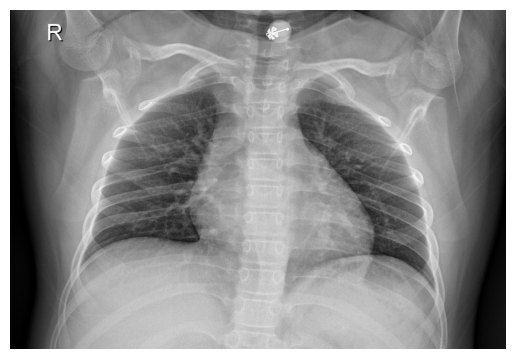


🚀 INICIANDO PIPELINE COMPLETO DE ANÁLISE...
-------------------------------------------------------
▶️ [Agente 1: Preprocessador] preparando a imagem...
▶️ [Agente 2: Analista ML] classificando a imagem...
✅ [Agentes 1 & 2] Análise local concluída. Diagnóstico: NORMAL
▶️ [Agente 3: Relator Gemini] gerando o laudo clínico...
✅ [Agente 3] Laudo clínico gerado.
⏸️ Pausa de 10 segundos para garantir a renovação da cota da API...
▶️ [Agente 4: Pesquisador Web] buscando informações online...
✅ [Agente 4] Pesquisa web concluída.
⏸️ Pausa de 10 segundos...
▶️ [Agente 5: Finalizador] compilando o documento final...


✅ [Agente 5] Documento final compilado.

📄 DOCUMENTO FINAL COMPILADO PELO PIPELINE

AVISO: Este é um projeto de estudo que explora como a Inteligência Artificial pode auxiliar profissionais de saúde. Não é uma ferramenta de diagnóstico e seus resultados são gerados apenas para fins demonstrativos. A avaliação de um profissional qualificado é sempre indispensável para qualquer decisão clínica.



# Relatório Final

**Data e Hora:** 09/07/2025 às 02:32:50

## Laudo Clínico

**Sumário da Análise:**
A análise de IA indica um resultado normal com alta confiança.

**Observações:**
Não foram identificadas anormalidades nas imagens analisadas.

**Ação Recomendada:**
Proceder com a rotina padrão de laudo, considerando a análise da IA como um dado adicional de suporte. A avaliação final e liberação do laudo são de responsabilidade do radiologista.

## Pesquisa Adicional

Nenhuma pesquisa adicional necessária para diagnóstico normal.

## AVISO

**AVISO:** Este é um projeto de estudo que explora como a Inteligência Artificial pode auxiliar profissionais de saúde. Não é uma ferramenta de diagnóstico e seus resultados são gerados apenas para fins demonstrativos. A avaliação de um profissional qualificado é sempre indispensável para qualquer decisão clínica.


In [46]:
# ===================================================================
# CÉLULA DE EXECUÇÃO DO PIPELINE COMPLETO
# ===================================================================
import asyncio
import time

# --- Orquestração do Pipeline de 5 Agentes ---
async def executar_pipeline_completo():
    # 1. Seleciona uma imagem aleatória para o teste
    caminho_base = './chest-xray-pneumonia/chest_xray/test'
    categoria_escolhida = random.choice(['NORMAL', 'PNEUMONIA'])
    caminho_imagens_categoria = os.path.join(caminho_base, categoria_escolhida)
    imagem_escolhida = random.choice(os.listdir(caminho_imagens_categoria))
    caminho_completo_imagem = os.path.join(caminho_imagens_categoria, imagem_escolhida)

    print(f"Imagem de teste selecionada: {os.path.basename(caminho_completo_imagem)}")
    print(f"Categoria Real: {categoria_escolhida}")
    img_display = Image.open(caminho_completo_imagem)
    plt.imshow(img_display, cmap='gray'); plt.axis('off'); plt.show()

    print("\n🚀 INICIANDO PIPELINE COMPLETO DE ANÁLISE...")
    print("-" * 55)

    # Etapa 1 e 2 (Execução Local)
    dados_processados = agente_preprocessador(caminho_completo_imagem)
    dados_analisados = agente_analista_ml(dados_processados, modelo_ia_local)
    print(f"✅ [Agentes 1 & 2] Análise local concluída. Diagnóstico: {dados_analisados['diagnostico']}")

    # Etapa 3 (Primeira chamada à API)
    dados_com_laudo = await agente_relator_gemini(dados_analisados)
    print("✅ [Agente 3] Laudo clínico gerado.")

    # PAUSA ESTRATÉGICA: Essencial para respeitar o limite da API gratuita e evitar erros.
    print("⏸️ Pausa de 10 segundos para garantir a renovação da cota da API...")
    time.sleep(10)

    # Etapa 4 (Segunda chamada à API)
    dados_com_pesquisa = await agente_pesquisador_web(dados_com_laudo)
    print("✅ [Agente 4] Pesquisa web concluída.")

    # PAUSA ESTRATÉGICA
    print("⏸️ Pausa de 10 segundos...")
    time.sleep(10)

    # Etapa 5 (Terceira chamada à API)
    resultado_final = await agente_finalizador(dados_com_pesquisa)
    print("✅ [Agente 5] Documento final compilado.")

    # Exibe o resultado final e completo do pipeline
    print("\n" + "="*55)
    print("📄 DOCUMENTO FINAL COMPILADO PELO PIPELINE")
    print("="*55)
    print("""
AVISO: Este é um projeto de estudo que explora como a Inteligência Artificial pode auxiliar profissionais de saúde. Não é uma ferramenta de diagnóstico e seus resultados são gerados apenas para fins demonstrativos. A avaliação de um profissional qualificado é sempre indispensável para qualquer decisão clínica.
""")
    display(Markdown(resultado_final.get("documento_final", "Erro ao gerar documento final.")))


# --- Executa a função principal do pipeline ---
await executar_pipeline_completo()

#AVISO:
 Este é um projeto de estudo que explora como a Inteligência Artificial pode auxiliar profissionais de saúde. Não é uma ferramenta de diagnóstico e seus resultados são gerados apenas para fins demonstrativos. A avaliação de um profissional qualificado é sempre indispensável para qualquer decisão clínica.


##Conclusão
Este projeto demonstrou com sucesso a criação de um pipeline de ponta a ponta usando um Sistema Multiagente. Ficou claro como a divisão de tarefas complexas em responsabilidades menores, atribuídas a agentes especializados, pode criar soluções de IA robustas e compreensíveis.

O estudo reforça o potencial da Inteligência Artificial não como substituta, mas como uma poderosa ferramenta de suporte para profissionais, capaz de otimizar tempo, automatizar tarefas repetitivas e enriquecer a análise com dados relevantes, liberando os especialistas para focarem em decisões de alto nível e no cuidado ao paciente.

**Aviso Final:** Este é um protótipo de estudo e não deve ser utilizado para fins de diagnóstico clínico.